In [8]:
import numpy as np

def cross_entropy_loss(y, pred):
    l = -np.log(pred)*y  #calculate y*log(p) for each category of each sample of the batch
    individual_losses = np.sum(l, -1)  #sum over categories
    batch_loss = np.sum(individual_losses) #sum over samples
    return batch_loss, individual_losses

def softmax(z):
    
    #input
    # z a S*C matrix rows = samples, columns same dimension as number of categories
    m = np.max(z)   #normalize to avoid large numbers 
    e = np.exp(z - m)
    return e / e.sum(axis=1, keepdims=True) #[:,None]

def relu(v):
    return np.where(v>0., v, 0.)


def init(seed=1):
    
    global b1, w1, b2, w2
    global g_b1, g_w1, g_b2, g_w2
    
    np.random.seed(seed)
    w1 = 2*np.random.random((input_dim , layer1_dim)) - 1
    b1 = 2*np.random.random(layer1_dim) - 1
    w2 = 2*np.random.random((layer1_dim, output_dim)) - 1
    b2 = 2*np.random.random(output_dim) - 1

    g_b2 = np.zeros_like(b2)
    g_w2 = np.zeros_like(w2)
    g_b1 = np.zeros_like(b1)
    g_w1 = np.zeros_like(w1)

def forward(X):

    '''
    X is expected to be shape=(S,I) 
    S: is the number of samples in a batch
    I: the number of input values for each sample
    '''

    global b1, w1, b2, w2
    global g_b1, g_w1, g_b2, g_w2

    global layer1_v, layer1_o
    global layer2_v, layer2_o
    
    #forward 
    #matmul will return a matrix of size SxL1 where L1 is size of layer1
    layer1_v = np.matmul(X,w1) + b1
    layer1_o = relu(layer1_v)  #shape=(S,L1)

    layer2_v = np.matmul(layer1_o,w2) + b2  #shape=(S,C) where C is size of output=number of categories
    layer2_o = softmax(layer2_v)  #shape=(S,C)
    
    return layer2_o

def backrop_weights(X,Y,alpha):

    global b1, w1, b2, w2
    global g_b1, g_w1, g_b2, g_w2

    global layer1_v, layer1_o
    global layer2_v, layer2_o
    
    g_b2 = np.zeros_like(b2)
    g_w2 = np.zeros_like(w2)
    g_b1 = np.zeros_like(b1)
    g_w1 = np.zeros_like(w1)
    
    g_loss_softmax = -(Y-layer2_o)  #shape=S,C
    print(g_loss_softmax)

    g_b2 = np.sum(g_loss_softmax, axis=0) #shape C; sum(axis=0) is sum over samples

    g_w2 = np.einsum("ij,ik",layer1_o, g_loss_softmax)
    print("layer1_o", layer1_o)
    
    dRelu = np.where(layer1_v>0., 1., 0.)  #shape=S,L1

    g_b1 += np.einsum("il,kl,ik->k",g_loss_softmax,w2,dRelu)

    g_w1 += np.einsum("il,kl,ik,ij->jk",g_loss_softmax,w2,dRelu,X)
    
    b2 -= alpha * g_b2 / X.shape[0] #average over number of samples
    w2 -= alpha * g_w2 / X.shape[0]
    b1 -= alpha * g_b1 / X.shape[0]
    w1 -= alpha * g_w1 / X.shape[0]
    
    return g_b1, g_w1, g_b2, g_w2

def train(X, Y, num_periods, alpha=0.1):
    
    global b1, w1, b2, w2
    global g_b1, g_w1, g_b2, g_w2
    
    for p in range(num_periods):
        
        batch_X = X #[0:1,:]
        batch_Y = Y #[0:1,:]
        #print("batch_X:",batch_X)
        
        pred = forward(batch_X)
        loss, _ = cross_entropy_loss(batch_Y, pred)  #loss scalar, _ is vector of size S, total loss for entire batch, loss for each sample of batch
        #print(p,loss)

        '''
        eps=0.001
        fg_b2 = np.zeros_like(b2)
        for i in range(b2.shape[0]):
            b2[i] += eps
            loss1, _ = cross_entropy_loss(batch_Y, forward(batch_X))
            fg_b2[i] = (loss1-loss)/eps
            b2[i] -= eps
        forward(X)

        eps=0.001
        fg_b1 = np.zeros_like(b1)
        for i in range(b1.shape[0]):
            b1[i] += eps
            loss1, _ = cross_entropy_loss(batch_Y, forward(batch_X))
            fg_b1[i] = (loss1-loss)/eps
            b1[i] -= eps
        forward(X)

        eps=0.001
        fg_w2 = np.zeros_like(w2)
        for i in range(w2.shape[0]):
            for j in range(w2.shape[1]):
                w2[i][j] += eps
                loss1, _ = cross_entropy_loss(batch_Y, forward(batch_X))
                fg_w2[i][j] = (loss1-loss)/eps
                w2[i][j] -= eps
        forward(X)
        
        eps=0.001
        fg_w1 = np.zeros_like(w1)
        for i in range(w1.shape[0]):
            for j in range(w1.shape[1]):
                w1[i][j] += eps
                loss1, _ = cross_entropy_loss(batch_Y, forward(batch_X))
                fg_w1[i][j] = (loss1-loss)/eps
                w1[i][j] -= eps
        forward(batch_X)
       ''' 
        
        backrop_weights(batch_X, batch_Y,alpha)
#        print(fg_b1, g_b1)
#        print(fg_b2, g_b2)
#        print(fg_w1, g_w1)
#        print(fg_w2,g_w2)

    
    return loss, pred

input_dim = 3
layer1_dim = 4
output_dim = 2  #2 classes


X_train = np.array([[0,0,1], 
                    [0,1,0],
                    [0,1,1],
                    [1,0,0],
                    [1,0,1]])

Y_train = np.array([[0,1],
                    [1,0],
                    [0,1],
                    [1,0],
                    [0,1]])

init()
train(X_train, Y_train, 1)


[[ 0.33810181 -0.33810181]
 [-0.51517717  0.51517717]
 [ 0.41493877 -0.41493877]
 [-0.54353703  0.54353703]
 [ 0.39578836 -0.39578836]]
layer1_o [[0.         0.83386834 0.         0.71137402]
 [0.         0.         0.         0.03205647]
 [0.         0.01854553 0.         0.40249548]
 [0.         1.19688386 0.         0.        ]
 [0.         1.27451733 0.         0.31603917]]


(2.960732484246908,
 array([[0.33810181, 0.66189819],
        [0.48482283, 0.51517717],
        [0.41493877, 0.58506123],
        [0.45646297, 0.54353703],
        [0.39578836, 0.60421164]]))

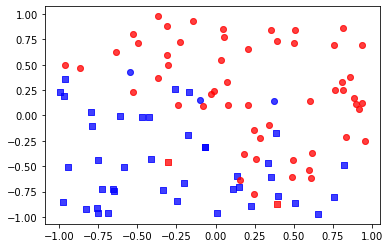

In [3]:
import matplotlib.pyplot as plt


input_dim = 3
layer1_dim = 5
output_dim = 2  #2 classes

S=100 #number of samples

X1 = 2*np.random.rand(S,3) - 1

Y1 = np.zeros((S,2))
Y1[:,0] = np.where(X1[:,0]+X1[:,1]+X1[:,2]>0,1,0)
Y1[:,1] = np.where(X1[:,0]+X1[:,1]+X1[:,2]>0,0,1)



#plt.scatter(X1[:,0],X1[:,1],c=color,alpha=0.5)
init(1)
train(X1,Y1,100, alpha=0.1)

pred = forward(X1)

color = np.where(Y1[:,0]>0,"red","blue")
marker = np.where(pred[:,0]>0.5,"o","s")

fig = plt.figure()
#ax = fig.add_subplot(projection='3d')
ax = fig.add_subplot()
for i in range(X1.shape[0]):
    ax.scatter(X1[i,0],X1[i,1],c=color[i],marker=marker[i],alpha=0.5)
    ax.scatter(X1[i,0],X1[i,1],c=color[i],marker=marker[i],alpha=0.5)
plt.show()